# System design Assumptions
- small antenna area 0.3 m x 2 m
- Low Peak Power ~ 200 W i.e. 1/6 Synspective
- High Duty cycle (to compensate for the low peak power) ~ 25%
- Losses + Noise Figure = 10dB (conservative)
- Resolution Area < 2m^2 (like terraSar spotlight)
- Pfa <= 10^-6 i.e. less than 1 fa for NZ EEZ
- 30 m x 7 m vessels to be detected
- LEO = 500 km


In [17]:
# antenna
la = 2  # m
wa = .3  # m
# losses + Nf
losses = 10  # dB
# orbit
h = 500e3  # m
# resolution area
ares = 2  # m2
# duty cycle
dutycycle = 0.25
# power
P_peak = 200  # W
pavg = dutycycle * P_peak  # W
# frequency
freq = 10e9
# wavelength
wavel = 299792458.0 / freq
# speed of light
c = 299792458.0

print('P_avg: ', pavg)

P_avg:  50.0


In [18]:
# probability of detection and false alarm
# expected value and variance for MEDIUM ships (150m>L>25m) (from Table 1 in DLR paper) better performance are expected given the higher resolution
# related to the intensity log normal distribution of ships
expected = - 0.002
variance = 4.66

# 30 m x 7 m vessels
A_ship = 30 * 7

#Pfa = 1 * A_ship / 10 ** 7
Pfa = 10e-6

# minimum probability of detection
pd_min = 0.5


In [19]:
# dependencies
import numpy as np
from design_functions import *
import matplotlib.pyplot as plt
import matplotlib
from timing_diagram import time_diagram_plotter
from radartools.farField import UniformAperture
from spherical_earth_geometry_radar import *
from scipy.optimize import fsolve, bisect

# I Rationale
-	For a set of physical parameters for the antenna, power and resolution area
-	Assuming that we are using the High resolution azimuthally ambiguous acquisition mode
-	For different looking angles (possible coverage given an orbit)

We need to find what’s the largest possible swath, either limited by range ambiguities or the Probability of Detection:
-	**Probability of detection**: the probability of detection given a probability of false alarm is a function of NESZ i.e. gain pattern tapering and Resolution, which in turn depends on the local incidence angle, the signal bandwidth, and the Processed doppler bandwidth.
-	**Range ambiguities**: the standard design rule to limit Range ambiguities is to keep the swath set by the PRF so that this is equal or larger than the 3 dB elevation antenna beamwidth projected on the ground. Additionally, the PRF is constrained to avoid nadir returns.


In [20]:
theta_mean = np.array([30])

# II Widest Swath System Design Procedure
1.	Set the initial looking angle
2.	Find the signal bandwidth assuming a target resolution area e.g. Ares = 2m^2
3.	Compute the NESZ over range assuming a spherical earth model, an ideal aperture antenna of given size, the bandwidth of point 2, and a set of fixed system parameters (losses, noise figure, power etc.)
4.	Compute the Pd curve over range from the NESZ of point 3
5.	Threshold the Pd curve to a minimum level e.g. Pd = 0.5, and find the swath width.
6.	If the swath width is smaller than the 3-dB elevation beamwidth, consider the 3-dB beamwidth as the swath for the following steps. Else use the swath width of point 5
7.	Using the Swath Width of point 6. Find an initial PRF guess assuming a certain duty cycle e.g. 25 %. (quite large to allow for low peak power)
8.	Align the PRF of 7 to the closest timing diagram valid point to avoid nadir returns
9.	Re-Evaluate the Probability of detection at the swath edges given by the new PRF and duty cycle of point 8 and slightly change the looking angle to center the Probability of detection “beam”
10.	Save the results and try for a different incidence angle


Following the widest swath design procedure with intermediate steps plotting for debug.
All the steps will then be collected in a single fuction to produce a sweep over the looking angle

1. set theta

In [21]:
theta = theta_mean[0]

2. find the bandwidth

In [22]:
B = find_bandwidth(la, theta, ares)
print('Signal Bandwidth: ', B / 1e6, ' MHz')

Signal Bandwidth:  149.89622900000003  MHz


3.	Compute the NESZ over range assuming a spherical earth model, an ideal aperture antenna of given size, the bandwidth of point 2, and a set of fixed system parameters (losses, noise figure, power etc.)
4.	Compute the Pd curve over range from the NESZ of point 3
5.	Threshold the Pd curve to a minimum level e.g. Pd = 0.5, and find the swath width.

In [23]:
# geometry
radGeo = RadarGeometry()
# looking angle
looking_angle = incidence_angle_to_looking_angle(theta * np.pi / 180, h)
radGeo.set_rotation(looking_angle, 0, 0)
# altitude
radGeo.set_initial_position(0, 0, h)
# orbital speed
v_s = radGeo.orbital_speed()
radGeo.set_speed(v_s)
print('looking_angle: ', looking_angle * 180 / np.pi, 'deg')
print('orbital speed:', v_s, 'm/s')
# ideal aperture antenna
uniap = UniformAperture(la, wa, freq)

looking_angle:  27.620636562903183 deg
orbital speed: [7612.68398988] m/s


In [24]:
# elevation limits
el_width = wavel / wa
# incidence angle axis
incidence = np.linspace(theta * np.pi / 180 - el_width, theta * np.pi / 180 + el_width, 51)
# NESZ_core, aximuth resolution using nominal doppler bandwidth
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
# nominal doppler bandwidth for reference
Bd = nominal_doppler_bandwidth(la, theta * np.pi / 180, wavel, v_s, h)
print("nominal Doppler Bandwidth:", Bd, 'Hz')

nominal Doppler Bandwidth: [7613.3079469] Hz


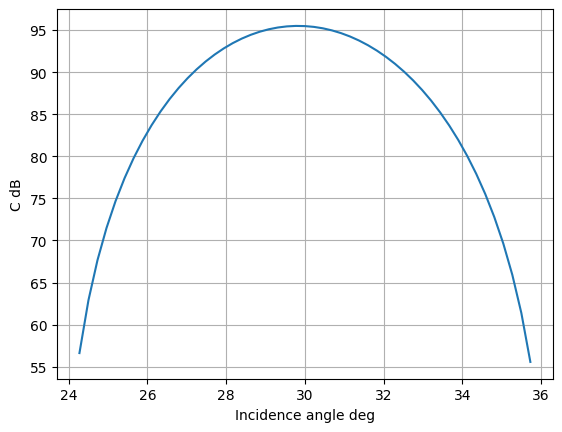

In [25]:
# core SNR plot
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(SNR_core))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('C dB')
ax.grid()

Parametrized NESZ
\begin{equation}
    NESZ = \dfrac{F\ L \ T_a\ B_n}{C\ P_{av}}
\end{equation}

In [26]:
Ta = 300  # k
NESZ = 10 ** (losses / 10) * Ta * B / (SNR_core * pavg)

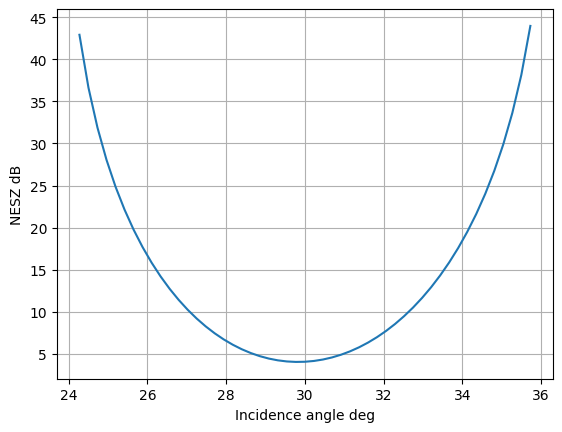

In [27]:
# NESZ plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(NESZ))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('NESZ dB')
ax.grid()

Probability of detection from NESZ, incidence angle and azimuth resolution
\begin{equation}
    \text{T}(P_fa) = -\text{NESZ} ln\left( \dfrac{P_{fa}\ A_{cell}}{A_{ship}} \right)
\end{equation}
\begin{equation}
    P_{d} &\approx 1 - \left[\dfrac{1}{2} + \dfrac{1}{2} \text{erf}\left( \dfrac{\ln(T) - \beta}{\sqrt{2V}} \right)\right]^ {\dfrac{A_{ship}}{A_{cell}}}
\end{equation}

In [28]:
# resolution
A_cell = daz * c / (2 * sin(incidence) * B)
# probability of detection
Pd = pd_from_nesz_res(NESZ, A_cell, Pfa, A_ship, expected, variance)

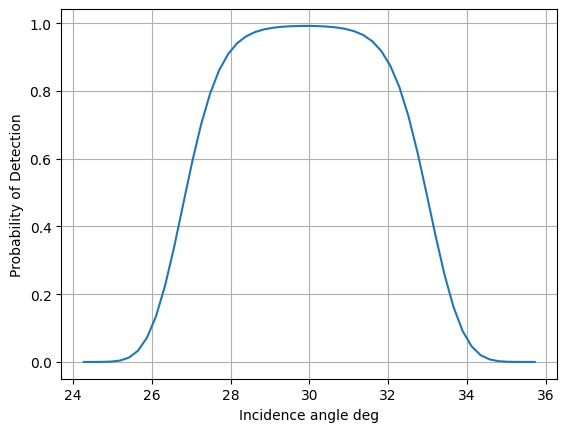

In [33]:
# probability of detection plotting
%matplotlib inline
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, Pd)
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('Probability of Detection')
ax.grid()

find the extremes given a Pd level
(can use a bisecant method for the two sides of the curve)

In [34]:
# 1 define the function to solve
def pd(radGeo, uniap, incidence, wavel, losses, bandwidth, p_avg, Pfa, A_ship, expected, variance):
    h = radGeo.S_0[2]
    v_s = radGeo.abs_v
    # core snr
    c_snr, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
    # parametrized NESZ
    Ta = 300  # k
    nesz = 10 ** (losses / 10) * Ta * bandwidth / (c_snr * p_avg)
    # probability of detection
    # resolution
    A_cell = daz * c / (2 * sin(incidence) * B)
    # probability of detection
    Pd = pd_from_nesz_res(nesz, A_cell, Pfa, A_ship, expected, variance)
    return Pd

In [35]:
# 2 solve the function for left and right with respect of broadside
func = lambda inc: pd(radGeo, uniap, inc, wavel, losses, B, pavg, Pfa, A_ship, expected, variance) - pd_min
# left problem
s_inc_right = theta * np.pi / 180 - 0.001
s_inc_left = theta * np.pi / 180 - el_width
# bisecant method
inc_left = bisect(func, s_inc_left, s_inc_right, full_output=True)
print(inc_left)
print("left extreme", inc_left[0] * 180 / np.pi)
# right problem
s_inc_right = theta * np.pi / 180 + el_width
s_inc_left = theta * np.pi / 180 + 0.0001
# bisecant method
inc_right = bisect(func, s_inc_left, s_inc_right, full_output=True)
print(inc_right)
print("right extreme", inc_right[0] * 180 / np.pi)

(0.4687797214015593,       converged: True
           flag: 'converged'
 function_calls: 38
     iterations: 36
           root: 0.4687797214015593)
left extreme 26.8590995576279
(0.5754933926775311,       converged: True
           flag: 'converged'
 function_calls: 38
     iterations: 36
           root: 0.5754933926775311)
right extreme 32.97334253808753


In [39]:

inc_pd = np.array([inc_left[0], inc_right[0]])
ax.plot(inc_pd * 180 / np.pi, pd_min * np.ones_like(inc_pd))
plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
